In [1]:
!pip install -q torchinfo

In [2]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

#reading files
import os
from torchvision.datasets.mnist import MNIST

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

#plots
import matplotlib.pyplot as plt

#model
import torch
from torch import nn, optim
import torchvision
from torchinfo import summary

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
print(is_cuda, device)

True cuda


In [4]:
seed = 322
random.seed(seed)         # python seed
np.random.seed(seed)      # numpy seed
torch.manual_seed(seed)   # torch seed
if device == 'cuda':
  torch.cuda.manual_seed_all(seed)  # gpu seed

In [5]:
def gaussian_noise(image, scale=0.8):
  noised = image + np.random.normal(loc=0, scale=scale, size=image.shape)
  noised = np.clip(noised, 0, 1)

  noised = torch.tensor(noised).float()
  return noised

In [6]:
base_dir = "dataset"
mnist = MNIST(base_dir, train=True, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 32.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.67MB/s]


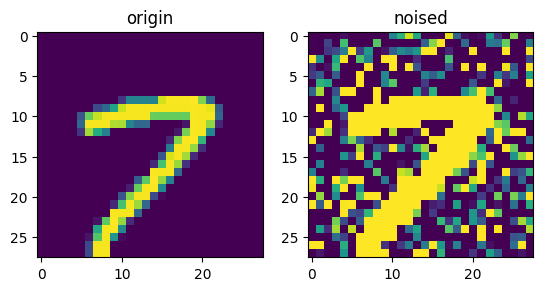

In [7]:
image = mnist.data[123]
plt.subplot(1, 2, 1)
plt.title("origin")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("noised")
plt.imshow(gaussian_noise(image))

In [8]:
class NoisedDataset(Dataset):
  def __init__(self, root, train):
    self.mnist = MNIST(root=root, train=train, download=True)

  def __getitem__(self, i):
    origin = self.mnist.data[i].unsqueeze(0)
    noised = gaussian_noise(origin)
    return noised/255., origin/255.

  def __len__(self):
    return len(self.mnist)

In [9]:
trainset = NoisedDataset(base_dir, True)

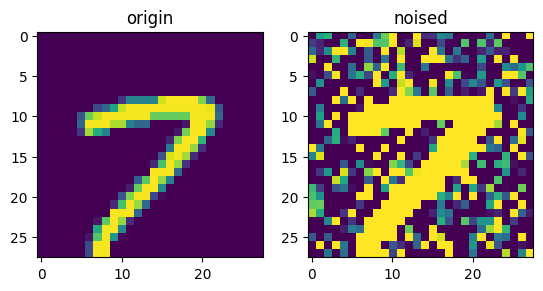

In [10]:
noised, origin = trainset[123]
plt.subplot(1, 2, 1)
plt.title("origin")
plt.imshow(origin.squeeze())
plt.subplot(1, 2, 2)
plt.title("noised")
plt.imshow(noised.squeeze())

In [11]:
def get_dataset(root):
  train = NoisedDataset(root, True)
  val = NoisedDataset(root, False)

  return train, val

trainset, valset  = get_dataset(base_dir)
print(len(trainset), len(valset))

60000 10000


In [12]:
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, hidden_dims):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, hidden_dims, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(hidden_dims, out_channels, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

    self.block = nn.Sequential(
      self.conv1,
      self.relu,
      self.conv2,
      self.relu
    )

  def forward(self, x):
    return self.block(x)

In [13]:
block = BasicBlock(1, 10, 4)
block(torch.rand((1, 8, 8))).shape

torch.Size([10, 8, 8])

In [14]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()

    self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dims=16)
    self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dims=8)
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    self.encoder = nn.Sequential(
      self.conv1,
      self.pool,
      self.conv2,
      self.pool
    )

  def forward(self, x):
    return self.encoder(x)

In [15]:
encoder = Encoder()
encoder(torch.rand((1, 8, 8))).shape

torch.Size([8, 2, 2])

In [16]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dims=8)
    self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dims=16)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=1,
                           kernel_size=3, padding=1)

    self.upsample1 = nn.ConvTranspose2d(in_channels=8, out_channels=8,
                                        kernel_size=2, stride=2)
    self.upsample2 = nn.ConvTranspose2d(in_channels=16, out_channels=16,
                                        kernel_size=2, stride=2)
    self.decoder = nn.Sequential(
      self.conv1,
      self.upsample1,
      self.conv2,
      self.upsample2,
      self.conv3
    )

  def forward(self, x):
    return self.decoder(x)

In [17]:
decoder = Decoder()
decoder(torch.rand((8, 2, 2))).shape

torch.Size([1, 8, 8])

In [18]:
class CAE(nn.Module):
  def __init__(self):
    super(CAE, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x.squeeze()

In [19]:
cae = CAE()
cae(torch.rand((1, 8, 8))).shape

torch.Size([8, 8])

In [20]:
summary(cae, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [28, 28]                  --
├─Encoder: 1-1                           [8, 7, 7]                 --
│    └─Sequential: 2-1                   [8, 7, 7]                 --
│    │    └─BasicBlock: 3-1              [16, 28, 28]              2,480
│    │    └─AvgPool2d: 3-2               [16, 14, 14]              --
│    │    └─BasicBlock: 3-3              [8, 14, 14]               1,744
│    │    └─AvgPool2d: 3-4               [8, 7, 7]                 --
├─Decoder: 1-2                           [1, 28, 28]               --
│    └─Sequential: 2-2                   [1, 28, 28]               --
│    │    └─BasicBlock: 3-5              [8, 7, 7]                 1,168
│    │    └─ConvTranspose2d: 3-6         [8, 14, 14]               264
│    │    └─BasicBlock: 3-7              [16, 14, 14]              3,488
│    │    └─ConvTranspose2d: 3-8         [16, 28, 28]              1,040

In [21]:
def train(model, dataloader, criterion, optimizer, epoch, device):
  model.train()

  running_loss = 0

  with tqdm(dataloader) as pbar:
    for i, (images, targets) in enumerate(pbar):
      images, targets = images.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs.squeeze(), targets.squeeze())

      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      pbar.set_postfix(loss=loss.item())

  return running_loss/len(dataloader)

In [22]:
def validation(model, dataloader, criterion, epoch, device):
  model.eval()

  running_loss = 0.
  with tqdm(dataloader) as pbar:
    with torch.no_grad():
      for i, (images, targets) in enumerate(pbar):
        images, targets = images.to(device), targets.to(device)

        outputs = model(images)
        loss = criterion(outputs.squeeze(), targets.squeeze())

        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

  print(f'[{epoch}/{EPOCH}] valid loss: {running_loss/len(dataloader):.4f}\n')

  return running_loss/len(dataloader)

In [23]:
EPOCH = 10
BATCH_SIZE = 32
NUM_WORKERS = 1
LR = 0.001

trainset, valset = get_dataset(base_dir)

# dataloader
train_loader = DataLoader(
  dataset=trainset,
  shuffle=True,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)
val_loader = DataLoader(
  dataset=valset,
  batch_size=BATCH_SIZE,
  num_workers=NUM_WORKERS,
)

# Model
model = CAE()

# Optimizer, Loss, Scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

model = model.to(device)
criterion = criterion.to(device)

# Start Training
min_loss = 999
for epoch in range(EPOCH):
  print("LR:", scheduler.get_last_lr())

  tloss = train(model, train_loader, criterion, optimizer, epoch, device)
  vloss = validation(model, val_loader, criterion, epoch, device)
  scheduler.step()

  if vloss < min_loss:
    print(f"Update Best Model: {vloss}")
    torch.save(model.state_dict(), "best.pth")
    min_loss = vloss

LR: [0.001]


100%|██████████| 313/313 [00:03<00:00, 89.40it/s, loss=0.021] 


[0/10] valid loss: 0.0220

Update Best Model: 0.022008712477863027
LR: [0.001]


100%|██████████| 313/313 [00:03<00:00, 98.66it/s, loss=0.0132] 


[1/10] valid loss: 0.0129

Update Best Model: 0.012911908438625618
LR: [0.001]


100%|██████████| 313/313 [00:03<00:00, 98.95it/s, loss=0.0109]  


[2/10] valid loss: 0.0116

Update Best Model: 0.011600691030700556
LR: [0.0005]


100%|██████████| 313/313 [00:03<00:00, 97.74it/s, loss=0.0111]  


[3/10] valid loss: 0.0110

Update Best Model: 0.010963074690379654
LR: [0.0005]


100%|██████████| 313/313 [00:03<00:00, 98.24it/s, loss=0.0118]  


[4/10] valid loss: 0.0109

Update Best Model: 0.010885933399224243
LR: [0.0005]


100%|██████████| 313/313 [00:03<00:00, 100.65it/s, loss=0.0109] 


[5/10] valid loss: 0.0106

Update Best Model: 0.010616260068937422
LR: [0.00025]


100%|██████████| 313/313 [00:03<00:00, 97.63it/s, loss=0.00989] 


[6/10] valid loss: 0.0103

Update Best Model: 0.010336391886654563
LR: [0.00025]


100%|██████████| 313/313 [00:03<00:00, 98.53it/s, loss=0.0105]  


[7/10] valid loss: 0.0101

Update Best Model: 0.010072044924068184
LR: [0.00025]


100%|██████████| 313/313 [00:03<00:00, 101.71it/s, loss=0.0107] 


[8/10] valid loss: 0.0099

Update Best Model: 0.009890250230844791
LR: [0.000125]


100%|██████████| 313/313 [00:03<00:00, 99.32it/s, loss=0.00995] 


[9/10] valid loss: 0.0098

Update Best Model: 0.00979910399794531


torch.Size([1, 28, 28]) torch.Size([1, 28, 28])
tensor(0.0748)


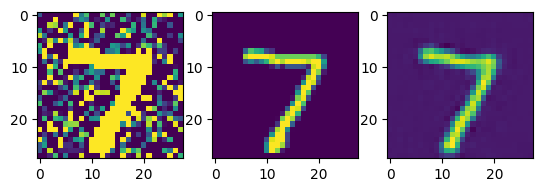

In [24]:
model = CAE()
# load best model
model.load_state_dict(torch.load("best.pth"))
model.eval()

with torch.no_grad():
  image, target = valset[0]
  print(image.shape, target.shape)
  print(nn.MSELoss()(image.squeeze(), target.squeeze()))

  output = model(image)

  plt.subplot(1, 3, 1)
  plt.imshow(image.squeeze())
  plt.subplot(1, 3, 2)
  plt.imshow(target.squeeze())
  plt.subplot(1, 3, 3)
  plt.imshow(output.squeeze())